In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from scipy import io
from sklearn.model_selection import KFold
from pathlib import Path

# Import necessary OAK modules (assuming the oak package is installed)
from oak.model_utils import oak_model, save_model
from oak.utils import (
    get_model_sufficient_statistics,
    get_prediction_component,
    extract_active_dims,
    get_list_representation,
    model_to_kernel_list,
)

# Set plotting preferences and random seeds for reproducibility
matplotlib.rcParams.update({"font.size": 20})
np.set_printoptions(formatter={"float": lambda x: "{0:0.5f}".format(x)})
np.random.seed(42)
tf.random.set_seed(42)

In [227]:
# Define synthetic functions
def f1(X):
    """Purely 1st order Smooth function: sin(2π*x₁) + x₂² + x₃"""
    return np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2 + 1 * X[:, 2]

def f2(X):
    """Purely 2nd order: Less smooth function with a localized bump"""
    base = np.sin(2 * np.pi * X[:, 0] * X[:, 2]) + 0.5 *  X[:, 1] * X[:, 2]
    bump = np.exp(-30 * np.abs(X[:,0]*X[:,1])) # localized bump which uses 2 dimensions
    return base + bump

def f3(X):
    """Purely 3rd order multiplicative term"""
    return X[:, 0] * X[:, 1] * X[:, 2]

In [228]:
# Generate synthetic datasets
N = 500  # number of samples
D = 3    # number of features
X = np.random.uniform(0, 1, (N, D))

# x_1 = np.random.normal(loc=0., scale=1, size=N)
# x_2 = np.random.normal(loc=0., scale=1, size=N)
# x_3 = np.random.normal(loc=0., scale=1, size=N)

#stack the features
# X = np.column_stack((x_1, x_2, x_3))



y1 = f1(X).reshape(-1, 1)  # dataset using f1
y2 = f2(X).reshape(-1, 1)  # dataset using f2
y3 = f3(X).reshape(-1, 1)  # dataset using f3



# Select one dataset to work with
X_data, y_data = X, y1

# renormalise y_data to be 0 mean, 1 variance
y_data = (y_data - y_data.mean()) / y_data.std()

In [229]:
# Split data into training and testing sets
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_index, test_index in kf.split(X_data):
    if fold == 0:
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
    fold += 1

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (400, 3)
Testing set shape: (100, 3)


In [230]:
# Train the Orthogonal Additive Kernel (OAK) Model
oak = oak_model(max_interaction_depth=X_train.shape[1])
oak.fit(X_train, y_train)

indices of binary feature  []
indices of continuous feature  [0, 1, 2]
indices of categorical feature  []
[None, None, None]
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.2369
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.425844
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.542707
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,0.00134241
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.184464
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,1.77414e-19
GPR.kernel.variances[3],Parameter,Softplus,Gamma,True,(),float64,2.39506e-20
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Training took 4.4 seconds.


In [231]:
# Evaluate the model on test data
x_min, x_max = X_train.min(0), X_train.max(0)
X_test_clipped = np.clip(X_test, x_min, x_max)

# Predict using the OAK model
y_pred = oak.predict(X_test_clipped)

# Compute metrics: RSS, TSS, R2, RMSE
rss = ((y_pred - y_test[:, 0]) ** 2).mean()
tss = ((y_test[:, 0] - y_test[:, 0].mean()) ** 2).mean()
r2 = 1 - rss / tss
rmse = np.sqrt(rss)
print(f"R2 = {r2:.5f}")
print(f"RMSE = {rmse:.5f}")

R2 = 1.00000
RMSE = 0.00221


In [232]:
# Calculate Sobol Indices for each kernel component
print("Calculating Sobol indices:")
oak.get_sobol()
tuple_of_indices = oak.tuple_of_indices
normalised_sobols = oak.normalised_sobols
print(f"Normalized Sobol indices: {normalised_sobols}")
print(f"Kernel component indices: {tuple_of_indices}")

Calculating Sobol indices:
Normalized Sobol indices: [0.77896 0.11326 0.10777 0.00000 0.00000 0.00000 0.00000]
Kernel component indices: [[0], [1], [2], [0, 1], [0, 2], [1, 2], [0, 1, 2]]


In [233]:
# Get predictions for each kernel component
# Transform test inputs and get sufficient statistics for prediction
XT = oak._transform_x(X_test_clipped)
oak.alpha = get_model_sufficient_statistics(oak.m, get_L=False)

# Get predicted contributions for each kernel component
prediction_list = get_prediction_component(oak.m, oak.alpha, XT)

# Compute the constant term (bias) from the model.
constant_term = oak.alpha.numpy().sum() * oak.m.kernel.variances[0].numpy()
print(f"Constant term: {constant_term:.5f}")
y_pred_component = np.ones(y_test.shape[0]) * constant_term

# Cumulatively add the predictions of each component (ordered by normalized Sobol indices)
cumulative_sobol, rmse_component = [], []
order = np.argsort(normalised_sobols)[::-1]
for n in order:
    y_pred_component += prediction_list[n].numpy()
    y_pred_component_transformed = oak.scaler_y.inverse_transform(y_pred_component.reshape(-1, 1))
    error_component = np.sqrt(((y_pred_component_transformed - y_test) ** 2).mean())
    rmse_component.append(error_component)
    cumulative_sobol.append(normalised_sobols[n])
cumulative_sobol = np.cumsum(cumulative_sobol)

# Sanity check: cumulative prediction should match overall model prediction
np.testing.assert_allclose(y_pred_component_transformed[:, 0], y_pred)

Constant term: 0.03631


In [234]:
oak.m.kernel.variances[0]

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.0013424122991329726>

Mutual Information

In [235]:
# Mutual Information Calculations for OAK Model Components
# Total variance from the model's predictions
V_total = np.var(y_pred)
print(f"Total Variance (V_total): {V_total:.5f}")

# Compute the variance explained by each component
sigma_components = np.array(normalised_sobols) * V_total

# Calculate MI for each component (in nats)
MI_components_nats = 0.5 * np.log(V_total / (V_total - sigma_components))
print("Mutual Information for each kernel component (in nats):")
for i, mi in enumerate(MI_components_nats):
    print(f"Component {tuple_of_indices[i]}: MI = {mi:.5f} nats")

# Convert MI from nats to bits (1 nat = 1/ln(2) bits)
MI_components_bits = MI_components_nats / np.log(2)
print("\nMutual Information for each kernel component (in bits):")
for i, mi in enumerate(MI_components_bits):
    print(f"Component {tuple_of_indices[i]}: MI = {mi:.5f} bits")

Total Variance (V_total): 1.08947
Mutual Information for each kernel component (in nats):
Component [0]: MI = 0.75471 nats
Component [1]: MI = 0.06010 nats
Component [2]: MI = 0.05702 nats
Component [0, 1]: MI = 0.00000 nats
Component [0, 2]: MI = 0.00000 nats
Component [1, 2]: MI = 0.00000 nats
Component [0, 1, 2]: MI = 0.00000 nats

Mutual Information for each kernel component (in bits):
Component [0]: MI = 1.08882 bits
Component [1]: MI = 0.08671 bits
Component [2]: MI = 0.08226 bits
Component [0, 1]: MI = 0.00000 bits
Component [0, 2]: MI = 0.00000 bits
Component [1, 2]: MI = 0.00000 bits
Component [0, 1, 2]: MI = 0.00000 bits


In [236]:
# total MI in bits
total_MI_bits = MI_components_bits.sum()
print(f"\nTotal Mutual Information: {total_MI_bits:.5f} bits")


Total Mutual Information: 1.25779 bits


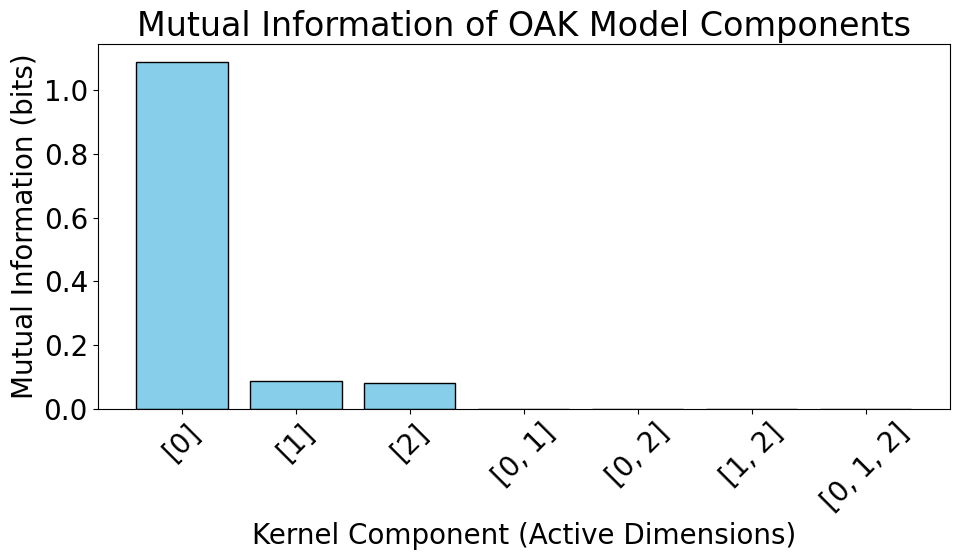

In [237]:
# Plot Mutual Information per Kernel Component
component_labels = [str(tup) for tup in tuple_of_indices]
plt.figure(figsize=(10, 6))
plt.bar(component_labels, MI_components_bits, color='skyblue', edgecolor='black')
plt.xlabel("Kernel Component (Active Dimensions)")
plt.ylabel("Mutual Information (bits)")
plt.title("Mutual Information of OAK Model Components")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [238]:
# Joint Mutual Information Calculation
chosen = 0  # choose a component to calculate joint MI, note 0 indexed
selected_indices = [i for i, dims in enumerate(tuple_of_indices) if chosen in dims]
if len(selected_indices) > 0:
    sigma_joint = np.sum(sigma_components[selected_indices])
    MI_joint_nats = 0.5 * np.log(V_total / (V_total - sigma_joint))
    MI_joint_bits = MI_joint_nats / np.log(2)
    print(f"Joint Mutual Information for components including x{chosen+1}: {MI_joint_nats:.5f} nats, or {MI_joint_bits:.5f} bits")
else:
    print(f"No components include {chosen+1}.")

Joint Mutual Information for components including x1: 0.75471 nats, or 1.08882 bits
